In [542]:
# Import Libraries
import pandas as pd
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt

# Importing statistics libraries
import statsmodels.api as sm
import scipy
from scipy import stats

#show plot in notebook
%matplotlib inline 

#limits amount of lines pandas prints out
from pandas import set_option 
set_option('display.max_rows', 10)

# Importing and Cleaning Data

In [216]:
#Loading the main dataset from excel into python, specified taking data from the 'Sales' sheet
Sales_df = pd.read_excel('../data/SalesDataA.xlsm', sheetname = 'Sales')
# Renaming the columns 
Sales_df.columns = [['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 'Year_of_First_Order', 'New_or_Returning']]
Sales_df.head()

,Exchange_Rate,Customer,Field,Date_of_Order,Total_Sales,Year_of_First_Order,New_or_Returning
0,NaN,ABB Australia,engine technology,2010-08-04,1897.60,NaN,Returning
1,NaN,A&A Metal Products,engine technology,2010-08-16,28963.00,NaN,Returning
2,NaN,Analytical Engineer.,engine technology,2010-08-20,76339.00,NaN,Returning
3,NaN,Bombardier Inc.,aerospace,2010-08-27,24318.92,NaN,New
4,NaN,Beef Products Inc.,food,2010-09-15,35084.00,NaN,New


In [448]:
# Replacing the empty values in the Exchange Rate column with 1 and setting the index to Date_of_Order
Exchange_df= Sales_df[['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 'Year_of_First_Order', 'New_or_Returning']].replace([None], [1])
# Creating a new column in the data set, which puts all sales amounts in Canadian dollars. 
Exchange_df['Sales_in_CAD'] = Exchange_df['Exchange_Rate'] * Exchange_df['Total_Sales']
Exchange_df.head()

,Exchange_Rate,Customer,Field,Date_of_Order,Total_Sales,Year_of_First_Order,New_or_Returning,Sales_in_CAD
0,1,ABB Australia,engine technology,2010-08-04,1897.60,1,Returning,1897.60
1,1,A&A Metal Products,engine technology,2010-08-16,28963.00,1,Returning,28963.00
2,1,Analytical Engineer.,engine technology,2010-08-20,76339.00,1,Returning,76339.00
3,1,Bombardier Inc.,aerospace,2010-08-27,24318.92,1,New,24318.92
4,1,Beef Products Inc.,food,2010-09-15,35084.00,1,New,35084.00


The reason why the empty exchange rate values are replaced with 1 is because for these dates the exchange rate between Canadian and US dollars was basically 1, so the person entering the data did not bother writing in a value. 

In [153]:
# Creating a new dataframe that includes all values with the Sales in CAD 
# All rows with dates under 2012-07-31 will be deleted
Change_New = Exchange_df[Exchange_df.index > '2012-07-31'].reset_index()
Change_New.head()

,Date_of_Order,Exchange_Rate,Customer,Field,Total_Sales,Year_of_First_Order,New_or_Returning,Sales_in_CAD
0,2012-08-01,1,Powerspan Corp.,alternative energy,11165.00,1,Returning,11165.00
1,2012-08-01,1,Multi Pression,solutions provider,1924.68,1,Returning,1924.68
2,2012-08-02,1,A&A Metal Products,engine technology,8765.00,1,Returning,8765.00
3,2012-08-03,1,Fluid Controls LTD,distributor,27750.00,1,New,27750.00
4,2012-08-07,1,ASM America,material science,170882.00,2012-05-01 00:00:00,Returning,170882.00


The reason why I deleted all rows before 2012-08-01, is because this data is not accurate (some of it is not sorted by month).  

# PLOT 1: Resampling data to make a plot that compares money spent on ads per month to sales coming from new customers & number of new customers.

In [449]:
# Deleting all rows of sales from returning customers, to obtain Sales only from new customers. 
New_customers = Change_New.groupby(['New_or_Returning']).get_group('New')
# Grabbing 3 columns from the dataset and setting the index to Date of order.
Resampled_ind = New_customers[['Date_of_Order', 'Total_Sales', 'New_or_Returning']].set_index('Date_of_Order')
Resampled_ind.head()

,Total_Sales,New_or_Returning
Date_of_Order,,
2012-08-03,27750.00,New
2012-08-08,916.12,New
2012-08-13,4389.00,New
2012-08-24,12854.40,New
2012-09-07,2144.10,New


In [450]:
# Replacing the 'New' string with the number 1 so that they can be added later. 
# And data is downsampled to month, taking the sum of the Sales and the new customers in each month. 
Index_Month= Resampled_ind[['New_or_Returning', 'Total_Sales']].replace(['New'], [1]).resample('M', how=('sum')) 
Index_Month.head()

,New_or_Returning,Total_Sales
Date_of_Order,,
2012-08-31,4,45909.52
2012-09-30,1,2144.10
2012-10-31,4,18763.53
2012-11-30,5,24919.22
2012-12-31,1,3278.00


In [451]:
# Deleting all rows that have a date before 2013-08-31. Keeping only two business years 2013 - 2015. The reason why I dont 
# want data before this date, is because the Ad cost data which will be used for comparison only starts on this date. 
Downsampled_month = Index_Month[Index_Month.index > '2013-08-30']
Downsampled_month.head()

,New_or_Returning,Total_Sales
Date_of_Order,,
2013-08-31,3,7410.00
2013-09-30,4,13538.40
2013-10-31,5,9627.02
2013-11-30,10,40999.01
2013-12-31,5,35721.00


Importing a new dataset (Cost of Ads per month), coming from a different sheet in the same excel file. 

In [452]:
#Loading another dataset from excel into python from a different sheet, and making the Date column the index.
Ads_df = pd.read_excel('../data/SalesDataA.xlsm', sheetname = 'Ads', index_col='Date')

In [453]:
# Renaming the column
# Resampling the date column, so that the month is synonymous with the other table 
Ads_df.columns = ['Ad_Cost']
Ads_df = Ads_df.resample('M', how=('sum'))   
Ads_df.head()

,Ad_Cost
Date,
2013-08-31,947.94
2013-09-30,936.06
2013-10-31,935.72
2013-11-30,930.47
2013-12-31,948.00


In [454]:
# Combining the two dataframes by the date of order, and resetting the index.
Combined_df = pd.concat([Downsampled_month, Ads_df], axis=1, join_axes=[Downsampled_month.index]).reset_index()
Combined_df.head()

,Date_of_Order,New_or_Returning,Total_Sales,Ad_Cost
0,2013-08-31,3,7410.00,947.94
1,2013-09-30,4,13538.40,936.06
2,2013-10-31,5,9627.02,935.72
3,2013-11-30,10,40999.01,930.47
4,2013-12-31,5,35721.00,948.00


C:\Users\mim\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


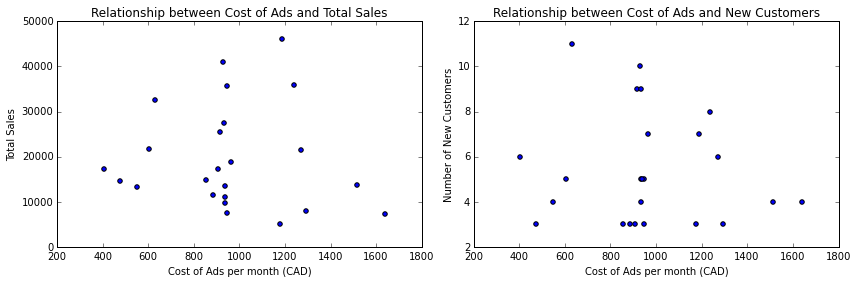

In [455]:
# Creating plots that compare cost of ads to Sales and Number of new customers. 
plt.figure(figsize=(12,4))

#Subplot 1
plt.subplot(1,2,1)
plt.scatter(Combined_df.Ad_Cost, Combined_df.Total_Sales)
plt.title('Relationship between Cost of Ads and Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Cost of Ads per month (CAD)')

#Subplot 2 
plt.subplot(1,2,2)
plt.scatter(Combined_df.Ad_Cost, Combined_df.New_or_Returning)
plt.title('Relationship between Cost of Ads and New Customers')
plt.ylabel('Number of New Customers')
plt.xlabel('Cost of Ads per month (CAD)')

plt.tight_layout()

We can now run linear regression analysis on these two plots, to see whether there is a relationship between the variables. 

In [456]:
# Running linear regression on the first subplot and showing the parameters. 
lm = sm.formula.ols(formula='Ad_Cost ~ Total_Sales', data = Combined_df).fit()
lm.params

Intercept      997.834610
Total_Sales     -0.001855
dtype: float64

In [585]:
# creating a dataframe to produce a list of numbers from 1 to the same length as the x axis
new_x = pd.DataFrame({'Ad_cost' : range(1, 1800)})
    
# using the .predict to predict the y based on x
y_preds = lm.predict(new_x)
    


PatsyError: Error evaluating factor: NameError: name 'Date_of_Order' is not defined
    Sales_in_CAD ~ Date_of_Order
                   ^^^^^^^^^^^^^

#PLOT 2: Plotting the distribution of sales over the years 2013- 2015 by month (Instead of plotting Sales, could plot the number of customers too). 

In [512]:
# Creating a dataframe with Date of Order as the index column
Distribution_df = Exchange_df[['Date_of_Order', 'New_or_Returning', 'Sales_in_CAD']].set_index('Date_of_Order').resample('M', how=('sum')) 
# Downsampling the dataframe to have only values after 2012-07-30
Distribution_df = Distribution_df[Distribution_df.index > '2012-07-31'].reset_index()
Distribution_df.head()

,Date_of_Order,Sales_in_CAD
0,2012-08-31,266208.49
1,2012-09-30,242972.33
2,2012-10-31,78000.68
3,2012-11-30,165319.22
4,2012-12-31,8561.60


In [500]:
#Creating a new column of month, by taking the month out of the Date_of_Order column  
Distribution_df['Month'] = Distribution_df['Date_of_Order'].dt.month
Distribution_df.head()

,Date_of_Order,Sales_in_CAD,Month
0,2012-08-31,266208.49,8
1,2012-09-30,242972.33,9
2,2012-10-31,78000.68,10
3,2012-11-30,165319.22,11
4,2012-12-31,8561.60,12


Making 3 different tables to have one table per business year from 2013-2015. Make a function for this so you dont have to repeat the same thing 3 times!

In [501]:
# Defining a function that takes in two columns **I NEED HELP WITH THIS HOW DO YOU OUTPUT A TABLE WITH A NEW COLUMN USING A funct
def businessyear(x, y):
    '''Takes in two columns (one of them must be a date) of a dataframe and creates a table of one business year, 
    also exctracting the month out of the Date column'''
    # Extracting the month out of the Date column (column x)
    Month = x.dt.month

In [502]:
businessyear(Exchange_df.Date_of_Order, Exchange_df.Sales_in_CAD)

In [507]:
# Making a table for the business year 2014-2015
Year3_df = Distribution_df.drop(Distribution_df.index[:24])

# Making a table for the business year 2012-2013 
Year1_df = Distribution_df.drop(Distribution_df.index[12:])

# Making a table for the business year 2013-2014 only
Year2_df = Distribution_df.iloc[12:24]

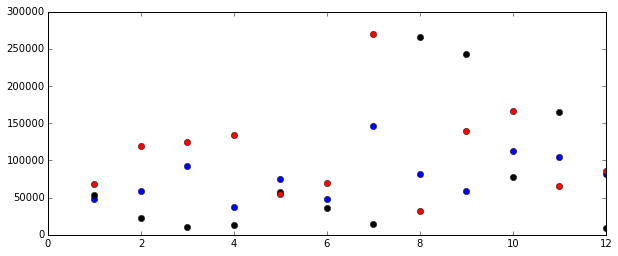

In [548]:
#Plotting all 3 business years on the same plot, each year in a different color.
plt.figure(figsize=(10,4))
plt.plot(Year2_df.Month, Year2_df.Sales_in_CAD, 'bo', Year1_df.Month, Year1_df.Sales_in_CAD, 'ko', 
         Year3_df.Month, Year3_df.Sales_in_CAD, 'ro')



We can now run a statistical analysis on this data. We can run the ANOVA test, which searches for differences in more than 2 groups. 

#PLOT3: Creating a boxplot that shows the distribution of sales across all fields, also showing how large individual Sales were. This will be done for all years combined first. 

In [522]:
# Groupby Field and Sales_in_CAD to keep each sales order seperate so we can later plot a boxplot which shows
# the distribution of sales. 
resampled_groups = Exchange_df.groupby(['Field', 'Sales_in_CAD']).sum()
resampled_groups.head()

Exchange_Rate  Total_Sales
Field     Sales_in_CAD                            
aerospace 124.5840             1.0740          116
          235.5885             1.2465          189
          505.0000             1.0000          505
          559.7100             1.2438          450
          1410.1620            1.0740         1313

In [523]:
# Resetting the index columns in order to plot 
resampled1_groups = resampled_groups.reset_index()

TypeError: unhashable type: 'slice'

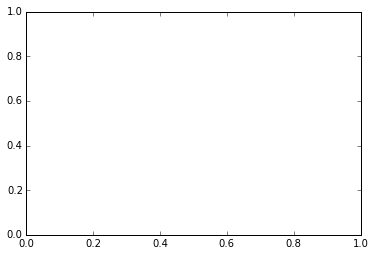

In [538]:
plt.violinplot(resampled1_groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x12d2d6a0>],
 'cbars': <matplotlib.collections.LineCollection at 0x12d335c0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x12d2d630>,
 'cmins': <matplotlib.collections.LineCollection at 0x12d33048>}

C:\Users\mim\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


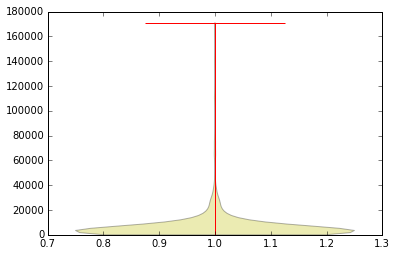

In [527]:
# Violin plot of all Sales in CAD
plt.violinplot(resampled1_groups['Sales_in_CAD'])

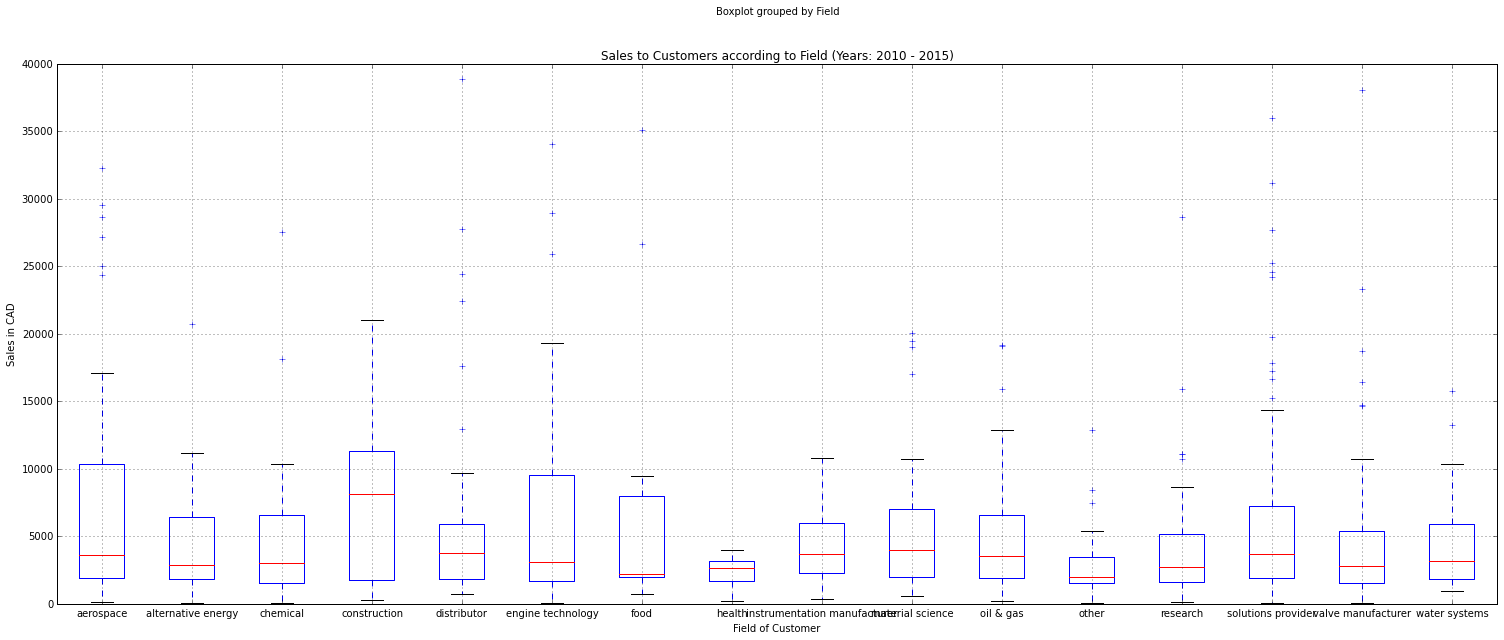

In [517]:
#Creating a boxplot of Sales according to the field a customer works in. This plot is for all years (2010 - 2015) combined
resampled1_groups.boxplot(by = 'Field', column='Sales_in_CAD', figsize=(25,10))

#Changing the y limit
plt.ylim(0, 40000)

plt.title('Sales to Customers according to Field (Years: 2010 - 2015)')
plt.xlabel('Field of Customer')
plt.ylabel('Sales in CAD')


Now I am trying to seperate each string in the Field column to create seperate plots, that will show the difference in sales in each years to see if there are any visible trends in any fields over the years. I would like to use a function for this to make it most efficient. 


In [251]:
# Creating a new table that contains only the columns that we need to create seperate plots for each field
Reset_ind = Exchange_df.reset_index()
Fields_df = Reset_ind[['Date_of_Order', 'Field', 'New_or_Returning', 'Sales_in_CAD']]
Fields_df.head()

,Date_of_Order,Field,New_or_Returning,Sales_in_CAD
0,2010-08-04,engine technology,Returning,1897.60
1,2010-08-16,engine technology,Returning,28963.00
2,2010-08-20,engine technology,Returning,76339.00
3,2010-08-27,aerospace,New,24318.92
4,2010-09-15,food,New,35084.00


In [252]:
# Trying to downsample data to business year, but it downsamples to year. 
Aerospace_an = aerospace_df.resample('BA', how=('sum'))  

In [226]:
# Creating a variable that contains all the names of the fields in the Field column
Fields = ['aerospace', 'oil & gas', 'alternative energy', 'engine technology', 'construction', 'research', 'water systems', 'distributor', 'solutions provider', 'other', 'instrumentation manufacturer', 'valve manufacturer', 'material science', 'chemical', 'food', 'health']

In [268]:
# Creating a dictionary that will contain each field seperately, so you can call each field with the dictionary
dic = {}

# Creating a FOR loop that will groupby a specified field in the field column of a dataframe.
for field in Fields:
    dic[field] = Fields_df.groupby(['Field']).get_group(field)

In [264]:
# Creating a variable for each field
research_df = dic['research']
oilgas_df = dic['oil & gas']
alternative_df = dic['alternative energy']


In [357]:
# Defining a function that will plot from a dataframe. The function takes in the two columns from a dataframe,
# that will be plotted on the x and y axis. 
def plot(x, y):
    plt.figure(figsize=(10,3))
    plt.plot(x, y, marker='o', linewidth=0)
    plt.ylim(-1000,)

Now I am trying to find which fields are interesting to look at. Which fields show interesting trends/fluctuations in sales. I plotted all fields using the plot function, however i only kept the fields which showed an interesting trend. 

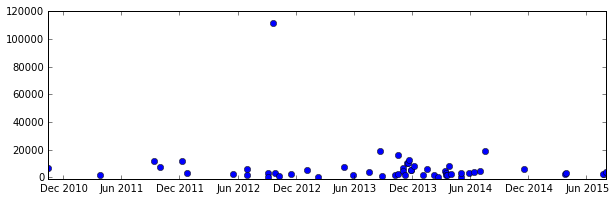

In [358]:
plot(dic['oil & gas']['Date_of_Order'], dic['oil & gas']['Sales_in_CAD'])

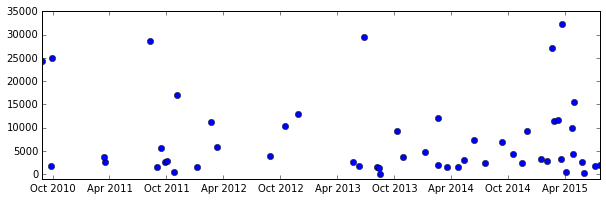

In [359]:
plot(dic['aerospace']['Date_of_Order'], dic['aerospace']['Sales_in_CAD'])

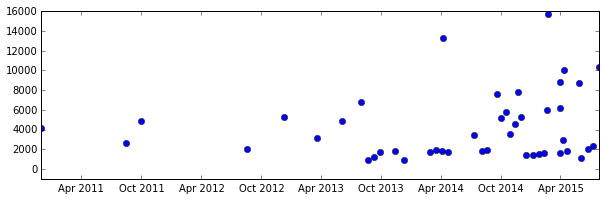

In [360]:
plot(dic['water systems']['Date_of_Order'], dic['water systems']['Sales_in_CAD'])

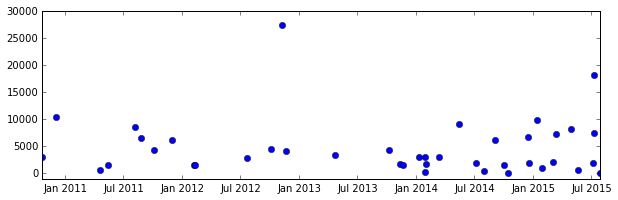

In [361]:
plot(dic['chemical']['Date_of_Order'], dic['chemical']['Sales_in_CAD'])

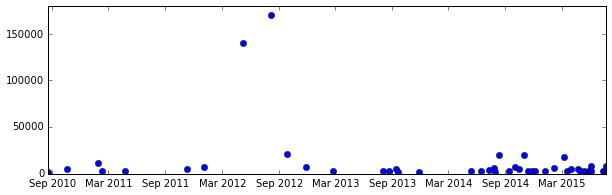

In [362]:
plot(dic['material science']['Date_of_Order'], dic['material science']['Sales_in_CAD'])

In [182]:
# Trying to make a function that takes out rows per business year from a dataframe
def businessyear(SalesData):
    '''Extracts all dates in a specific business year from a dataset,
    to create a new dataframe with just this year'''
    # Opening the data in the function
    # The r means read file
    with open (SalesData, 'r') as mySalesData:
        #Reading all of the lines in the dataframe
        file = mySalesData.readlines()
        
        # This creates a variable of the Date column
        dates = file.Date
        
        if dates == 2010:
            return ('You suck')

In [184]:
# Trying to resample by Business Annual, but its giving me annual and not business year..
Annual = Exchange_df.resample('BA', how=('sum'))   
Annual

,Exchange_Rate,Total_Sales,Sales_in_CAD
Date_of_Order,,,
2010-12-31,44.0000,387313.93,387313.930000
2011-12-30,118.0000,930863.16,930863.160000
2012-12-31,102.0000,1099685.08,1099685.080000
2013-12-31,135.4570,624541.03,648022.915760
2014-12-31,233.2395,921757.94,995491.338040
2015-12-31,166.0887,704583.36,842044.135884


#PLOT4: Creating a plot that shows sales to returning customers vs. Sales to new customers, to help determine whether it is more important to invest money in ads to target new customers, or to maintain old customers. 

In [185]:
# Grabbing 2 columns from a previously cleaned data set (Change_New) 
Customers_df = Change_New[['Sales_in_CAD', 'New_or_Returning']]
Customers_df.head()

,Sales_in_CAD,New_or_Returning
0,11165.00,Returning
1,1924.68,Returning
2,8765.00,Returning
3,27750.00,New
4,170882.00,Returning


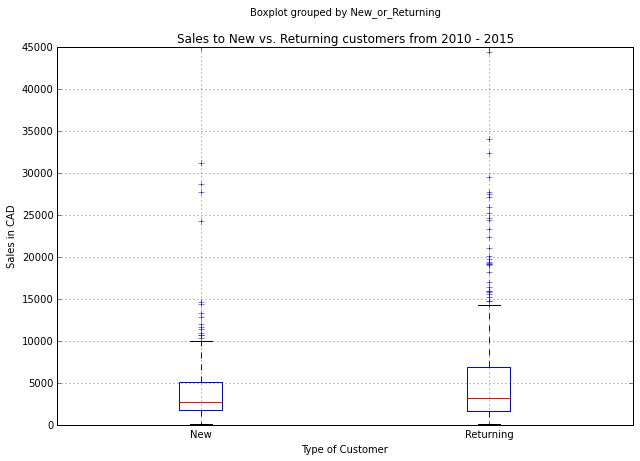

In [565]:
# Creating a boxplot of New versus Returning customer Sales.
Customers_df.boxplot(by = 'New_or_Returning', column='Sales_in_CAD', figsize=(10,7))
plt.ylim(0, 45000)
plt.title('Sales to New vs. Returning customers from 2010 - 2015')
plt.xlabel('Type of Customer')
plt.ylabel('Sales in CAD')


In [187]:
# Getting the columns New or Returning and Sales in CAD with the Date of Order to get 
# the amount of sales over time 
Type_date = Exchange_df[['New_or_Returning', 'Sales_in_CAD']]
Type_date.head()

,New_or_Returning,Sales_in_CAD
Date_of_Order,,
2010-08-04,Returning,1897.60
2010-08-16,Returning,28963.00
2010-08-20,Returning,76339.00
2010-08-27,New,24318.92
2010-09-15,New,35084.00


In [188]:
# Creating a dataframe of just Returning customers
Returning_df = Type_date.groupby(['New_or_Returning']).get_group('Returning ').reset_index()
Returning_df.head()

,Date_of_Order,New_or_Returning,Sales_in_CAD
0,2010-08-04,Returning,1897.60
1,2010-08-16,Returning,28963.00
2,2010-08-20,Returning,76339.00
3,2010-09-21,Returning,7219.00
4,2010-09-27,Returning,17622.61


In [189]:
# Creating a dataframe of only new customers
New_df = Type_date.groupby(['New_or_Returning']).get_group('New').reset_index()
New_df.head()

,Date_of_Order,New_or_Returning,Sales_in_CAD
0,2010-08-27,New,24318.92
1,2010-09-15,New,35084.00
2,2010-09-16,New,1563.00
3,2010-09-16,New,1550.00
4,2010-10-06,New,14357.60


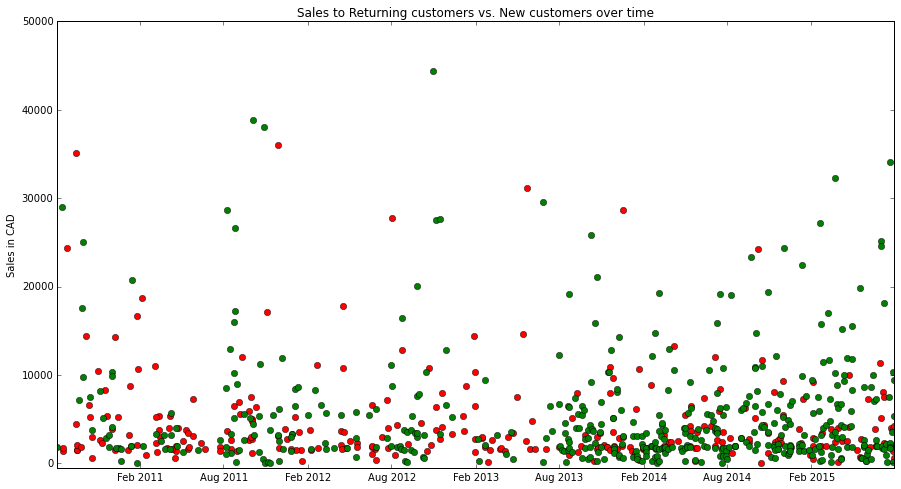

In [582]:
# Making a plot to compare Sales from New and Returning customers over time
plt.figure(figsize = (15,8))
plt.plot(New_df.Date_of_Order, New_df.Sales_in_CAD, 'ro', Returning_df.Date_of_Order, Returning_df.Sales_in_CAD, 'go')
plt.ylim(-500, 50000)

plt.ylabel('Sales in CAD')
plt.title ('Sales to Returning customers vs. New customers over time')

On this data, we can run an unpaired/ student's t - test to see whether sales to new customers and sales to returning customers are significantly different. 

In [570]:
def variance(columnname, n):
    '''assignes function to calculate the 
    standard error of a list or numpy array'''
    mean = sum(columnname)/n                        # creating a variable for the mean of the list/array
    std_part_1 = sum([(num-mean)**2 for num in columnname]) # creating a variable for the first caclulation of the standard deviation
    var = std_part_1/(n-1)         # Completing the standard deviation calculation 
    return(var)


In [571]:
variance(New_df.Sales_in_CAD, len(New_df.Sales_in_CAD))

92576890.092929989

In [572]:
variance(Returning_df.Sales_in_CAD, len(Returning_df.Sales_in_CAD))

242523522.74525771

In [573]:
# Running the t-test on the variance calculations of the new and returning customers
rvs1 = stats.norm.rvs(loc=92576890.092929989,scale=0.1,size=500)
rvs2 = stats.norm.rvs(loc=242523522.74525771,scale=0.2,size=500)
stats.ttest_ind(rvs1,rvs2)

(-14752385992.863649, 0.0)

The obtained p-value is 0.0, which means that the two variables (New and Returning Customers) are significantly different. This means that there is aboslutely no chance of an outside variable to create the differences between these two variables. 

We can also plot a line of best fit for each variable to compare the two. 

In [577]:
lm = sm.formula.ols(formula='Sales_in_CAD ~ Date_of_Order', data = New_df).fit() 
lm.params

Intercept                                             1454.400000
Date_of_Order[T.Timestamp('2010-08-18 00:00:00')]      248.460000
Date_of_Order[T.Timestamp('2010-08-27 00:00:00')]    22864.520000
Date_of_Order[T.Timestamp('2010-09-15 00:00:00')]    18338.355000
Date_of_Order[T.Timestamp('2010-09-16 00:00:00')]      285.366667
                                                         ...     
Date_of_Order[T.Timestamp('2015-07-10 00:00:00')]     3463.276050
Date_of_Order[T.Timestamp('2015-07-24 00:00:00')]     1589.592200
Date_of_Order[T.Timestamp('2015-07-28 00:00:00')]     1435.951200
Date_of_Order[T.Timestamp('2015-07-30 00:00:00')]      -82.400000
Date_of_Order[T.Timestamp('2015-07-31 00:00:00')]     1002.259000
dtype: float64

In [584]:
x_new = pd.DataFrame({'Date_of_Order' : range(1,700)})